<a href="https://colab.research.google.com/github/pallavibekal/IISC---Neural-Networks/blob/main/M4_Project_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification 

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:

 

*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below. 

![img](http://www.nada.kth.se/cvap/actions/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:** 

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN; 
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file; 
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability; 
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

^C
[Actions.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of Actions.zip or
        Actions.zip.zip, and cannot find Actions.zip.ZIP, period.
Dataset downloaded successfully!!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!wget -qq /content/drive/MyDrive/Actions.zip
!unzip -qq /content/drive/MyDrive/Actions.zip

### Import required packages

In [ ]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam

import os, glob
import cv2
import numpy as np

In [ ]:
import pandas as pd

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [ ]:
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"


In [ ]:
# Get file paths and labels
def extract_filenames (path):
  files = glob.glob(path + '/*')
  actions_list = []
  file_paths = []
  labels_list=[]
  for each in files:
    actions_list.append(each.split('/')[-1])
  for actions in actions_list:
    filepath = path + '/' + actions + '/*'
    filepaths = glob.glob(filepath)
    for x in filepaths:
      file_paths.append(x)
      labels_list.append(actions)
  return file_paths,labels_list


In [ ]:
data_filepaths_list, labels = extract_filenames(data_dir)
len(data_filepaths_list)

479

In [ ]:
train_df = pd.DataFrame(list(zip(data_filepaths_list, labels)),
               columns =['video_name', 'tag'])
train_df

,video_name,tag
0,/content/Actions/train//jogging/person03_joggi...,jogging
1,/content/Actions/train//jogging/person17_joggi...,jogging
2,/content/Actions/train//jogging/person01_joggi...,jogging
3,/content/Actions/train//jogging/person05_joggi...,jogging
4,/content/Actions/train//jogging/person14_joggi...,jogging
...,...,...
474,/content/Actions/train//boxing/person10_boxing...,boxing
475,/content/Actions/train//boxing/person01_boxing...,boxing
476,/content/Actions/train//boxing/person17_boxing...,boxing
477,/content/Actions/train//boxing/person24_boxing...,boxing


In [ ]:
train_df['video_name'][0]

'/content/Actions/train//jogging/person03_jogging_d2_uncomp.avi'

In [ ]:
data_filepaths_list, labels = extract_filenames(test_data_dir)
len(data_filepaths_list)

120

In [ ]:
test_df = pd.DataFrame(list(zip(data_filepaths_list, labels)),
               columns =['video_name', 'tag'])
test_df

,video_name,tag
0,/content/Actions/test//jogging/person07_joggin...,jogging
1,/content/Actions/test//jogging/person13_joggin...,jogging
2,/content/Actions/test//jogging/person18_joggin...,jogging
3,/content/Actions/test//jogging/person12_joggin...,jogging
4,/content/Actions/test//jogging/person19_joggin...,jogging
...,...,...
115,/content/Actions/test//boxing/person02_boxing_...,boxing
116,/content/Actions/test//boxing/person05_boxing_...,boxing
117,/content/Actions/test//boxing/person11_boxing_...,boxing
118,/content/Actions/test//boxing/person03_boxing_...,boxing


In [ ]:
files = glob.glob('/content/Actions/test/Handclapping' + '/*')
files

['/content/Actions/test/Handclapping/person11_handclapping_d4_uncomp.avi',
 '/content/Actions/test/Handclapping/person14_handclapping_d2_uncomp.avi',
 '/content/Actions/test/Handclapping/person06_handclapping_d4_uncomp.avi',
 '/content/Actions/test/Handclapping/person08_handclapping_d2_uncomp.avi',
 '/content/Actions/test/Handclapping/person08_handclapping_d4_uncomp.avi',
 '/content/Actions/test/Handclapping/person17_handclapping_d1_uncomp.avi',
 '/content/Actions/test/Handclapping/person11_handclapping_d3_uncomp.avi',
 '/content/Actions/test/Handclapping/person08_handclapping_d3_uncomp.avi',
 '/content/Actions/test/Handclapping/person12_handclapping_d2_uncomp.avi',
 '/content/Actions/test/Handclapping/person14_handclapping_d1_uncomp.avi',
 '/content/Actions/test/Handclapping/person16_handclapping_d4_uncomp.avi',
 '/content/Actions/test/Handclapping/person11_handclapping_d2_uncomp.avi',
 '/content/Actions/test/Handclapping/person14_handclapping_d4_uncomp.avi',
 '/content/Actions/test/H

In [ ]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 479
Total videos for testing: 120


,video_name,tag
50,/content/Actions/train//jogging/person25_joggi...,jogging
118,/content/Actions/train//handwaving/person24_ha...,handwaving
218,/content/Actions/train//Handclapping/person09_...,Handclapping
173,/content/Actions/train//Handclapping/person13_...,Handclapping
376,/content/Actions/train//running/person21_runni...,running
115,/content/Actions/train//handwaving/person05_ha...,handwaving
144,/content/Actions/train//handwaving/person08_ha...,handwaving
238,/content/Actions/train//Handclapping/person25_...,Handclapping
169,/content/Actions/train//Handclapping/person09_...,Handclapping
308,/content/Actions/train//Walking/person08_walki...,Walking


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 512

#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

In [ ]:
# For custom model
def new_load(path,max_frames=0,resize=(IMG_SIZE, IMG_SIZE)):
  cap = cv2.VideoCapture(path)
  frameCount = max_frames+1
  total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  frames_step = total_frames//frameCount

  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  buf = np.empty((frameCount, frameHeight,frameWidth,  3), np.dtype('uint8'))

  fc = 0
  i=0
  ret = True
  try:
    while True:
      if (fc < total_frames):
        #print('Came here 1')
        if i >= frameCount:
          break
        ret, buf[i] = cap.read()
        #print(ret)
        if not ret:
          break
        #buf[i] = crop_center_square(buf[fc])
        #buf[i]=cv2.resize(buf[i], resize)
        #print('Came here 2')
        fc += frames_step
        i+=1
        #print(fc)
      else:
        break
  finally:
    cap.release()
  #print(buf.shape) # (10, 540, 9
  return(np.array(buf),path.split('/')[-1].split('_')[1])

In [ ]:
x,y = new_load('/content/Actions/train//jogging/person03_jogging_d2_uncomp.avi',15)
x.shape, y

((16, 120, 160, 3), 'jogging')

In [ ]:
list_frames=[]
list_labels=[]
path = []
MAX_SEQ_LENGTH = 15
for video in train_df['video_name']:
  frames,labels = new_load(video,15)
  list_labels.append(labels)
  list_frames.append(frames)
#list_frames

In [ ]:
list_frames[0].shape

(16, 120, 160, 3)

In [ ]:
#input for custom model
frames_array = np.array(list_frames)

In [ ]:
#labels for custom model
labels_array = np.array(list_labels)

In [ ]:
set([i.shape[0] for i in list_frames])

{16}

In [ ]:
class_names = {"handclapping": 0, "walking":1, "boxing":2, "handwaving":3, "jogging":4, "running":5}

In [ ]:
y_pred = np.array(["handwaving", 'handclapping', 'handclapping', "boxing", "jogging", "jogging","walking",  "running"])

In [ ]:
y_pred = np.array([class_names[_] for _ in labels_array])

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=(16, 120, 160, 3)))
model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Flatten()))
 
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 60, 80, 32)   4736      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 58, 78, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 29, 39, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 29, 39, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 29, 39, 64)   3

In [ ]:
model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

#### Setup the parameters and train the model with epochs, batch wise 

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
history = model.fit(
        frames_array,
        y_pred,
        validation_split=0.3,
        epochs=5)
        #callbacks=[checkpoint],

Epoch 1/5
11/11 [==============================] - 303s 27s/step - loss: 1.6820 - accuracy: 0.2537 - val_loss: 3.9497 - val_accuracy: 0.0000e+00
Epoch 2/5
11/11 [==============================] - 297s 27s/step - loss: 1.6526 - accuracy: 0.2358 - val_loss: 3.7420 - val_accuracy: 0.0000e+00
Epoch 3/5
11/11 [==============================] - 294s 27s/step - loss: 1.6107 - accuracy: 0.2597 - val_loss: 3.9950 - val_accuracy: 0.0000e+00
Epoch 4/5
11/11 [==============================] - 300s 27s/step - loss: 1.6567 - accuracy: 0.2000 - val_loss: 4.4559 - val_accuracy: 0.0000e+00
Epoch 5/5
11/11 [==============================] - 298s 27s/step - loss: 1.6303 - accuracy: 0.2179 - val_loss: 4.5687 - val_accuracy: 0.0000e+00


In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
x,y = new_load(test_video,15)
x = np.expand_dims(x, axis=0)
x.shape
test_frames = model.predict(x)
#to_gif(test_frames[:15])
test_frames

Test video path: /content/Actions/test//handwaving/person10_handwaving_d2_uncomp.avi


array([[0.2667604 , 0.30017477, 0.00300985, 0.11839347, 0.26082632,
        0.05083518]], dtype=float32)

In [ ]:
class_names = {"handclapping": 0, "walking":1, "boxing":2, "handwaving":3, "jogging":4, "running":5}

In [ ]:
grp10net_pred = np.argmax(test_frames, axis=1)

print('Group 10 Net Predicted Class:', np.array(class_names)[test_frames])


### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

In [ ]:
# Prepare to use a pre trained model 
from keras.applications.inception_v3 import InceptionV3

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [ ]:
# For pre trained model 
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())


['Handclapping', 'Walking', 'boxing', 'handwaving', 'jogging', 'running']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (479, 20, 2048)
Frame masks in train set: (479, 20)


In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


In [ ]:
frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))    
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
(frame_features_input,mask_input)

(<KerasTensor: shape=(None, 20, 2048) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 20) dtype=bool (created by layer 'input_4')>)

In [ ]:
# Note: There will be a high memory requirement for the training steps below. 
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE

#### Load and fine-tune the pre-trained model

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [ ]:
_, sequence_model = run_experiment()

Epoch 1/10
10/11 [==========================>...] - ETA: 0s - loss: 1.4958 - accuracy: 0.3688
Epoch 00001: val_loss improved from inf to 2.51785, saving model to /tmp/video_classifier
11/11 [==============================] - 11s 332ms/step - loss: 1.4805 - accuracy: 0.3731 - val_loss: 2.5179 - val_accuracy: 0.0000e+00
Epoch 2/10
10/11 [==========================>...] - ETA: 0s - loss: 1.2458 - accuracy: 0.4781
Epoch 00002: val_loss improved from 2.51785 to 2.49639, saving model to /tmp/video_classifier
11/11 [==============================] - 1s 56ms/step - loss: 1.2377 - accuracy: 0.4866 - val_loss: 2.4964 - val_accuracy: 0.0000e+00
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 1.1542 - accuracy: 0.5284
Epoch 00003: val_loss did not improve from 2.49639
11/11 [==============================] - 1s 54ms/step - loss: 1.1542 - accuracy: 0.5284 - val_loss: 2.5401 - val_accuracy: 0.0000e+00
Epoch 4/10
10/11 [==========================>...] - ETA: 0s - loss: 1.1025 - ac

In [ ]:
pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-gyq5dzkx
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-gyq5dzkx
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=155860 sha256=4d8ad93a0a1ae57f53e2902d6fa041273714916a73e18b4f35347acea8f539a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-64qht0z0/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
import imageio
from tensorflow_docs.vis import embed

Test video path: /content/Actions/test//handwaving/person16_handwaving_d1_uncomp.avi
  handwaving: 32.17%
  Handclapping: 25.58%
  jogging: 14.51%
  Walking: 11.64%
  boxing: 10.02%
  running:  6.08%



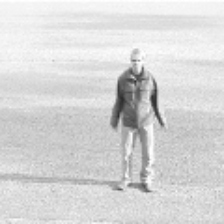

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification

In [ ]:
# Reference link - http://francescopochetti.com/video-classification-in-keras-a-couple-of-approaches/

In [ ]:
#for reference only

def pre_trained():
  print("1")
  video = Input(shape=(MAX_SEQ_LENGTH,
                      IMG_SIZE,
                      IMG_SIZE,
                      channels))
  #image = preprocess_input(video)
  print("11")
  cnn_base = VGG16(input_shape=(IMG_SIZE,
                                IMG_SIZE,
                                channels),
                  weights="imagenet",
                  include_top=False)
  print("12")
  cnn_out = GlobalAveragePooling2D()(cnn_base.output)
  print("13")
  cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
  print("14")
  cnn.trainable = False
  encoded_frames = TimeDistributed(cnn)(video)
  encoded_sequence = LSTM(256)(encoded_frames)
  hidden_layer = Dense(1024, activation="relu")(encoded_sequence)
  outputs = Dense(output, activation="softmax")(hidden_layer)
  model = Model([video], outputs)
  print("15")
  #optimizer = adam(lr=0.002,
  #                  beta_1=0.9,
  #                  beta_2=0.999,
  #                  epsilon=1e-08,
  #                  schedule_decay=0.004)
  model.compile(loss="categorical_crossentropy",
                optimizer='adam',
                metrics=["categorical_accuracy"]) 
  return model 

In [ ]:
# Utility for running experiments.
def run_experiment():
    filepath = "/tmp1/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )
    print("1")
    pre_trained_model = pre_trained()
    print("2")
    history = pre_trained_model.fit(
        frames_np,
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )
    print("3")
    pre_trained_model.load_weights(filepath)
    print("4")
    _, accuracy = pre_trained_model.evaluate(test_data[0], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [ ]:
_, pretrained_model = run_experiment()

1
1
11
12
13
14
15
2
Epoch 1/10


ValueError: ignored